## Results comparision notebooks

In [ ]:
!pip install vit-keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit
import os
import cv2
import pandas as pd
from matplotlib.patches import Rectangle
from lxml import etree
from sklearn.preprocessing import LabelBinarizer

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/sample_data/Test'
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/Computer Vision course/DL/03 - SingleDetection-Tools/'

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Computer Vision course/DL/03 - SingleDetection-Tools/Data/Test.zip' -d '/content/sample_data/'

In [ ]:
Class_dict = {'drill_bit': 1,
 'cutter': 2,
 'allen_keys': 3,
 'tongs': 4,
 'screwdriver': 5,
 'screws_box': 6}

In [ ]:
# Function to parse and extract information from annotation files

def get_annotations(path):
    # Read the annotation file

    data = open(path, 'rb')

    xslt_content = data.read()
    sel = etree.XML(xslt_content)

    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])
    # Extract the bounding box coordinates
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Extract class
    label = str(sel.xpath("//object/name/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height,label]

In [ ]:
def load_image(path, size):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,3)
    image = tf.image.resize(image,[size,size])
    image = tf.cast(image,tf.float32)
    image = image / 255.

    return image

def create_dataset(coors, path, batch, Class_dict, size):
    # zip agrupa los ith elementos de cada lista y los convierte en lista
    xmin, ymin, xmax, ymax, label = list(zip(*coors))

    labels = [Class_dict[a]-1 for a in label]

    # Convert to Numpy array
    xmin = np.array(xmin)
    ymin = np.array(ymin)
    xmax = np.array(xmax)
    ymax = np.array(ymax)
    label = np.array(labels)

    labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label))

    imgs = []
    listSorted = os.listdir(path)
    listSorted.sort()

    for i in listSorted:
        if i[-4:] == '.jpg':
            imgs.append(os.path.join(path,i))

    dataset = tf.data.Dataset.from_tensor_slices(imgs)
    dataset = dataset.map(lambda path: load_image(path, size))

    dataset_label = tf.data.Dataset.zip((dataset, labels_dataset))

    dataset_label = dataset_label.shuffle(64).batch(batch)

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    dataset_label = dataset_label.cache().prefetch(buffer_size=AUTOTUNE)

    return dataset_label

In [ ]:
def get_list_annotations(path_folder):

    items = os.listdir(path_folder)
    items.sort()
    xml = []

    for item in items:
        if item[-4:] == '.xml':
            xml.append(os.path.join(path_folder,item))

    return [get_annotations(path) for path in xml]

In [ ]:
test_coors = get_list_annotations(PATH)
batch_valid = 4
test_dataset = create_dataset(test_coors, PATH, batch_valid, Class_dict, 224)

In [ ]:
mobilenet_model = tf.keras.models.load_model(DRIVE_PATH+'Models/MN_loc.h5')
transformer_model = tf.keras.models.load_model(DRIVE_PATH+'Models/ViT_loc.h5')

In [ ]:
conv_res = mobilenet_model.evaluate(test_dataset)

23/23 [==============================] - 10s 38ms/step - loss: 2980.6384 - xmin_loss: 0.0130 - ymin_loss: 0.0333 - xmax_loss: 0.0109 - ymax_loss: 0.0325 - class_loss: 2980.5486 - xmin_mae: 0.0924 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1517 - ymin_acc: 0.0222 - xmax_mae: 0.0861 - xmax_acc: 0.0000e+00 - ymax_mae: 0.1486 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 0.1667


In [ ]:
trans_res = transformer_model.evaluate(test_dataset)

23/23 [==============================] - 6s 76ms/step - loss: 16.4445 - xmin_loss: 0.0013 - ymin_loss: 0.0016 - xmax_loss: 0.0019 - ymax_loss: 0.0019 - class_loss: 16.4377 - xmin_mae: 0.0273 - xmin_acc: 0.0000e+00 - ymin_mae: 0.0320 - ymin_acc: 0.0222 - xmax_mae: 0.0305 - xmax_acc: 0.0000e+00 - ymax_mae: 0.0341 - ymax_acc: 0.0000e+00 - class_mae: 2.3889 - class_acc: 0.0000e+00


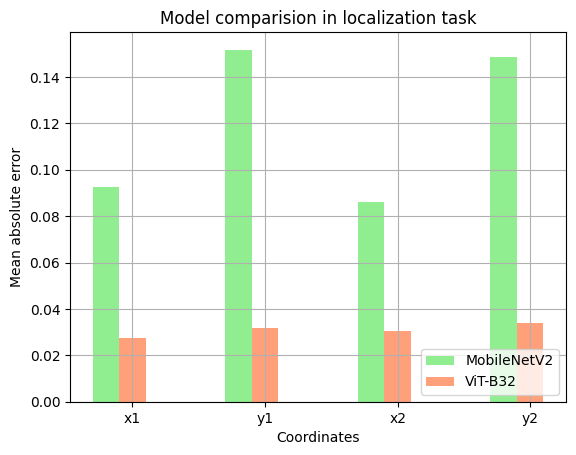

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.3
br1 = np.arange(0,6,1.5)
br2 = [x + barWidth for x in br1]

# Order (it can be seen in the training):
# These 3 groups only appears in the training
# - loss, xmin_loss, ymin_loss, xmax_loss, ymax_loss, class_loss
# - xmin_mae, xmin_acc, ymin_mae, ymin_acc, xmax_mae, xmax_acc, ymax_mae, ymax_acc
# - class_mae, class_acc

# - val_loss, val_xmin_loss, val_ymin_loss, val_xmax_loss, val_ymax_loss, val_class_loss
# - val_xmin_mae, val_xmin_acc, val_ymin_mae, val_ymin_acc, val_xmax_mae, val_xmax_acc, val_ymax_mae, val_ymax_acc
# - val_class_mae, val_class_acc

plt.bar(br1, [conv_res[6], conv_res[8], conv_res[10], conv_res[12]], color = 'lightgreen', width = barWidth, label = 'MobileNetV2')
plt.bar(br2, [trans_res[6], trans_res[8], trans_res[10], trans_res[12]], color = 'lightsalmon', width = barWidth, label = 'ViT-B32')

#max_tick = np.max(bars[0] + bars[1] + bars[2]) + 1

plt.xticks(br2, ['x1', 'y1', 'x2', 'y2'])
plt.legend(loc='lower right')
plt.xlabel('Coordinates')
plt.ylabel('Mean absolute error')
plt.title('Model comparision in localization task')
#plt.ylim(0,max_tick)
plt.grid()
plt.show()

#Assignment

Objetivo: Tratar de mejorar estos modelos usando YOLOv8

El profesor entregará un zip con las imágenes, etiquetas, fichero de configuración y un template de código

Deadline: 24 de enero